In [339]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [340]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [341]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from langchain_teddynote.tools.tavily import TavilySearch

In [342]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

In [343]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [344]:
llm = ChatOpenAI( 
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [345]:
tool = TavilySearch(max_results=1)      # 검색 도구 생성
tools = [tool]                          # 도구 목록에 넣기  

In [346]:
# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot(state: State):
    print('===== chatbot() 함수 시작 =====')
    
    print("[1] chatbot() 으로 넘어온 메시지: ")

    message_type1 = ''

    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            message_type1 = message_type1 + '[HumanMessage]'
        elif isinstance(msg, AIMessage):
            message_type1 = message_type1 + '[AIMessage]'
        elif isinstance(msg, ToolMessage):
            message_type1 = message_type1 + '[ToolMessage]'
        
        print(f'메시지 타입: {message_type1}')
        print(msg)
        print()

    print(f"\n[2] 메시지 개수 : {len(state['messages'])}\n")

    answer = llm_with_tools.invoke(state['messages'])

    # print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    
    print('[3] chatbot()에서 실행:')
    print('메시지 타입: ', end='')

    message_type2 = ''
    if isinstance(answer, AIMessage):
        message_type2 = message_type2 + '[AIMessage]'
    elif isinstance(answer, HumanMessage):
        message_type2 = message_type2 + '[HumanMessage]'
    elif isinstance(answer, ToolMessage):
        message_type2 = message_type2 + '[ToolMessage]'
    else:
        message_type2 = type(answer)

    print(message_type2)
    print(answer)
    print()

    answer_value = {'messages': [answer]}

    print(f"[4] chatbot()에서 실행 후 메시지 개수: {message_type1} {message_type2} {len(state['messages']) + len(answer_value)}") 
    print('===== chatbot() 함수  끝 =====')
    print()

    return answer_value

In [348]:
question = "대구 동성로 떡볶이에 대해서 검색해줘"

state = State(messages=[('user', question)])
chatbot(state)

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 메시지 타입: 
('user', '대구 동성로 떡볶이에 대해서 검색해줘')

[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_dAZT0mH0fLc9UN0zpJhwtnTT', 'function': {'arguments': '{"query":"대구 동성로 떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 105, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1c9b3378-1d4f-48d6-bd81-3b1292cf488e-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 동성로 떡볶이'}, 'id': 'call_dAZT0mH0fLc9UN0zpJhwtnTT', 'type': 'tool_call'}] usage_metadata={'inp

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dAZT0mH0fLc9UN0zpJhwtnTT', 'function': {'arguments': '{"query":"대구 동성로 떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 105, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1c9b3378-1d4f-48d6-bd81-3b1292cf488e-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 동성로 떡볶이'}, 'id': 'call_dAZT0mH0fLc9UN0zpJhwtnTT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 105, 'output_tokens': 27, 'total_tokens': 132, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_tok

In [349]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        self.tools_list = {tool.name: tool for tool in tools}
        print(f'======================================================')
        print('[BasicToolNode]')
        print('도구 호출 생성자')
        print(f'tools_list: {self.tools_list}')
        print(f'======================================================')
    
    def __call__(self, inputs: dict):
        if messages := inputs.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('No message found in input')
        
        print()
        print(f'======================================================')
        print('[BasicToolNode] call')
        #print('도구 호출로 갔을 때')
        #print('message.tool_calls:', message.tool_calls)
        #print(f'======================================================')

        outputs = []

        for tool_call in message.tool_calls:    # message의 tool_calls 속성이 있는것은 도구 호출을 필요한 메시지가 있는 경우
            print(f'도구 호출이 필요한 경우: ')
            print(f'도구 호출 : {tool_call}')
            print(f"도구 호출 이름: {tool_call['name']}")
            print(f"도구 호출 인자 : {tool_call['args']}")

            tool_result = self.tools_list[tool_call['name']].invoke(tool_call['args'])
            # print(f'도구 호출 결과 : {tool_result}')                                           
        
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False), 
                    name=tool_call['name'], 
                    tool_call_id=tool_call['id']
                )
            )
            
        print('[BasicToolNode] call 끝')
        print(f'======================================================')
        print()

        return {'messages': outputs}    

In [350]:
# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])   

[BasicToolNode]
도구 호출 생성자
tools_list: {'tavily_web_search': TavilySearch(client=<tavily.tavily.TavilyClient object at 0x0000020F456EB610>, max_results=1)}


In [351]:
from langchain_core.runnables import RunnableLambda

tool_node_runnable = RunnableLambda(tool_node)

In [352]:
sample_input = {
    "messages": [
        HumanMessage(content="대구 동성로 떡볶이에 대해서 알려줘"),
        AIMessage(
            content="",
            tool_calls=[{
                "name": 'tavily_web_search',            
                "args": {"query": "대구 동성로 떡볶이"},
                "id": "99c32be8-e500-4b2c-9675-34ab45fa6ab5"
            }]
        )
    ]
}

result = tool_node(sample_input)

for msg in result["messages"]:
        print(f"- {msg.name}: {msg.content}")


[BasicToolNode] call
도구 호출이 필요한 경우: 
도구 호출 : {'name': 'tavily_web_search', 'args': {'query': '대구 동성로 떡볶이'}, 'id': '99c32be8-e500-4b2c-9675-34ab45fa6ab5', 'type': 'tool_call'}
도구 호출 이름: tavily_web_search
도구 호출 인자 : {'query': '대구 동성로 떡볶이'}
[BasicToolNode] call 끝

- tavily_web_search: [{"title": "대구 동성로 즉석떡볶이 맛집 동성로 떡볶이 : 네이버 블로그", "url": "https://m.blog.naver.com/no2eunju/223774004249", "content": "동성로 떡볶이 대구 중구 동성로 19-7 10:00-22:00 (21:00라스트 오더) 주차공간 없음 대구 동성로는 대구에서도 번화가로 많이 알려진 곳이기도 하다. 예전에 풍등축제를 보러 갈때도 친구들과 대구의 먹자골목을 많이 둘러보기도 했고 이곳 동성로에서 즉석떡볶이를 먹은 기억이 추억으로 남았는데 지난", "score": 0.8399576, "raw_content": "블로그\n\n카테고리 이동\n\n\n\n\n언니의카메라\n\n대구 동성로 즉석떡볶이 맛집 동성로 떡볶이\n\n2025. 2. 26. 0:52\n\n대구 동성로 즉석떡볶이 맛집 동성로 떡볶이\n\n25년 1월 어느날\n\n​\n\n​\n\n동성로 떡볶이\n\n대구 중구 동성로 19-7\n\n10:00-22:00(21:00라스트 오더)\n\n주차공간 없음\n\n​\n\n​\n\n대구 동성로는 대구에서도 번화가로 많이 알려진 곳이기도 하다. 예전에 풍등축제를 보러 갈때도 친구들과 대구의 먹자골목을 많이 둘러보기도 했고 이곳 동성로에서 즉석떡볶이를 먹은 기억이 추억으로 남았는데 지난 겨울 친구들과 대구 여행을 떠났을때 급 땡겼던 즉석떡볶이 앓이 덕분에 방문하게 된 대구 동성로 즉석떡볶이 맛집 '

In [353]:
from langgraph.graph import StateGraph, START, END

def route_tools(state: State):

    if messages := state.get('messages', []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    print()
    print('===== 라우터 노드 =====')
    # print(f"라우터 노드로 넘어온 chatbot() 에서 생성한 state 메시지: ")
    # print(ai_message)

    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        print(f'라우터 [tools] : \n{ai_message.tool_calls}')
        print(f'라우터 리턴: tools')
        print('===== 라우터 노드 끝 =====')
        print()

        return 'tools'
    
    print(f'라우터 리턴: {END}')
    print('===== 라우터 노드 끝 =====')
    print()
    
    return END

In [354]:
state_with_tools = {
    "messages": [
        HumanMessage(
            content="대한민국 수도에 대해서 검색해줘",
            id='6e0ff6a0-d790-42a0-ae24-28172c7feabc'
        ),
        AIMessage(
            content="",
            tool_calls=[{
                "name": "tavily_web_search",                        
                "args": {"query": "대한민국 수도"},
                "id": "call_k6ljrhTRP8dz8FwNrtbyyG3K"
            }],
            additional_kwargs={
                "tool_calls": [{
                    "id": "call_k6ljrhTRP8dz8FwNrtbyyG3K",
                    "function": {
                        "arguments": json.dumps({"query": "대한민국 수도"}),
                        "name": "tavily_web_search"                     
                    },
                    "type": "function"
                }],
                "refusal": None
            },
            response_metadata={
                "token_usage": {
                    "completion_tokens": 20,
                    "prompt_tokens": 99,
                    "total_tokens": 119
                },
                "model_name": "gpt-4o-mini-2024-07-18"
            },
            id='run-164b42b2-a16c-4ea8-8a2e-94da55991426-0'
        )
    ]
}


route_tools(state_with_tools)


===== 라우터 노드 =====
라우터 [tools] : 
[{'name': 'tavily_web_search', 'args': {'query': '대한민국 수도'}, 'id': 'call_k6ljrhTRP8dz8FwNrtbyyG3K', 'type': 'tool_call'}]
라우터 리턴: tools
===== 라우터 노드 끝 =====



'tools'

In [355]:
graph_builder = StateGraph(State)

In [356]:
graph_builder.add_node('chatbot', chatbot)

In [357]:
# 그래프에 도구 노드 추가
graph_builder.add_node('tools', tool_node) 

In [358]:
graph_builder.add_conditional_edges(
    source='chatbot', 
    path=route_tools, 
    path_map={'tools': 'tools', END: END}
)

In [359]:
graph_builder.add_edge(START, 'chatbot')

In [360]:
graph_builder.add_edge('tools', 'chatbot')

In [361]:
graph = graph_builder.compile()

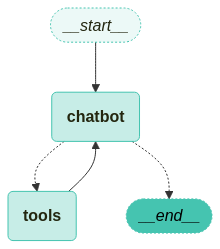

In [362]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [ ]:
import json

question = '대구 동서로 떡볶이에 대해서 검색해줘'

state = State(messages=[('user', question)])

for event in graph.stream(state):
    print()
    print('========================= 여기서 시작 ====================')
    print('[event] 바깥 for 시작')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] content: {value['messages'][-1].content}")

            if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                print('tool call 있음')

                tool_result = value['messages'][-1].tool_calls

                print(f"도구 이름 : {tool_result[0]['name']}")
                print(f"도구 인자: {tool_result[0]['args']}")            
            else:
                print('tool call 없음')                
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content : \n{value['messages'][-1].content}")
            # print(f"[해당 노드 값] 도구 name : {value['messages'][-1].name}")
            print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:                
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
        
    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 메시지 타입: [HumanMessage]
content='대구 동서로 떡볶이에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='7905ca4d-2ed5-421d-95bf-68a85441aa89'

[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_4diflWcF3j7dSzvrF2pfntOh', 'function': {'arguments': '{"query":"대구 동서로 떡볶이"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 105, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1ad3fda6-10fd-4a1c-8c85-3673b228759c-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 

In [364]:
from langchain_teddynote.messages import display_message_tree

inputs = {"messages": "대한민국 수도에 대해서 검색해줘"}

for event in graph.stream(input=inputs, stream_mode='values'):
    for key, value in event.items():
        print(f'==========\nSTEP: {key} \n==========\n')
        display_message_tree(value[-1])

STEP: messages 

    content: "대한민국 수도에 대해서 검색해줘"
    additional_kwargs: {}
    response_metadata: {}
    type: "human"
    name: None
    id: "234dee39-bce8-42d3-b82a-27790fd6c633"
    example: False
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 메시지 타입: [HumanMessage]
content='대한민국 수도에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='234dee39-bce8-42d3-b82a-27790fd6c633'

[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_Sf4Z769zLxDM5bBbRlBqVqyi', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 99, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 's

In [ ]:
""" 
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 메시지 타입: [HumanMessage]
content='대구 동서로 떡볶이에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='29885b8f-f7e6-4dcd-9428-bc36a1566183'

[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' 
additional_kwargs=
 {
   'tool_calls': 
                   [
                     {
                       'id': 'call_fXE5wULmCQohXWAvrVZqBF1w', 
                       'function': 
                                    {
                                       'arguments': '{"query":"대구 동서로 떡볶이"}', 
                                       'name': 'tavily_web_search'
                                    }, 
                       'type': 'function'
                     }
                   ], 
   'refusal': None
} 

response_metadata=
  {
    'token_usage': 
      {
        'completion_tokens': 27, 
        'prompt_tokens': 105, 
        'total_tokens': 132, 
        'completion_tokens_details': 
          {
            'accepted_prediction_tokens': 0, 
            'audio_tokens': 0, 
            'reasoning_tokens': 0, 
            'rejected_prediction_tokens': 0
          }, 
        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
      }, 

    'model_name': 'gpt-4o-mini-2024-07-18', 
    'system_fingerprint': 'fp_b8bc95a0ac', 
    'finish_reason': 'tool_calls', 
    'logprobs': None
  } 

id='run-5fc13baf-0231-4bd5-b3cb-8b356ac82394-0'

tool_calls=
 [
  {
     'name': 'tavily_web_search', 
     'args': {'query': '대구 동서로 떡볶이'}, 
     'id': 'call_fXE5wULmCQohXWAvrVZqBF1w', 
     'type': 'tool_call'
  }
 ] 

usage_metadata=
  {
    'input_tokens': 105, 
    'output_tokens': 27, 
    'total_tokens': 132, 
    'input_token_details': {'audio': 0, 'cache_read': 0}, 
    'output_token_details': {'audio': 0, 'reasoning': 0}
  }

[4] chatbot()에서 실행 후 메시지 개수: [HumanMessage] [AIMessage] 2
===== chatbot() 함수  끝 =====


===== 라우터 노드 =====
라우터 [tools] : 
[{'name': 'tavily_web_search', 'args': {'query': '대구 동서로 떡볶이'}, 'id': 'call_fXE5wULmCQohXWAvrVZqBF1w', 'type': 'tool_call'}]
라우터 리턴: tools
===== 라우터 노드 끝 =====


=================================== 여기서 시작 ===================================
[event] 바깥 for 시작

실행한 노드 이름: chatbot

==================== AIMessage ========================
[해당 노드 값] content: 
tool call 있음
도구 이름 : tavily_web_search
도구 인자: {'query': '대구 동서로 떡볶이'}
==================== END AIMessage ====================

바깥 for 끝
========================= 여기서 끝 =========================


======================================================
[BasicToolNode] call
도구 호출이 필요한 경우: 
도구 호출 : {'name': 'tavily_web_search', 'args': {'query': '대구 동서로 떡볶이'}, 'id': 'call_fXE5wULmCQohXWAvrVZqBF1w', 'type': 'tool_call'}
도구 호출 이름: tavily_web_search
도구 호출 인자 : {'query': '대구 동서로 떡볶이'}
[BasicToolNode] call 끝
======================================================


=================================== 여기서 시작 ===================================
[event] 바깥 for 시작

실행한 노드 이름: tools

==================== ToolMessage ========================
[해당 노드 값] 도구 도구 이름 : tavily_web_search
[해당 노드 값] 제목: 동성로 떡볶이 본점 + 즉석떡볶이 맛집 : 네이버 블로그
[해당 노드 값] URL: https://m.blog.naver.com/ssung0904/223797136192
[해당 노드 값] 내용: 대구 시내 떡볶이 맛집, 동성로떡볶이. 골목 안쪽에 위치 했지만, 떡볶이 골목 입구. 간판이 떡하니 있어, 어렵지 않게 찾을 수 있어요 대구 중구 동성로 19-7 (중구 사일동 79) 영업시간, 매일 10:00~22:00 (라스트오더 21:00) 동성로떡볶이 본점, 주차장은 x
==================== END ToolMessage ====================

바깥 for 끝
========================= 여기서 끝 =========================

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 

메시지 타입: [HumanMessage]
content='대구 동서로 떡볶이에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='29885b8f-f7e6-4dcd-9428-bc36a1566183'

메시지 타입: [HumanMessage][AIMessage]
content='' 
additional_kwargs={
                    'tool_calls': 
                      [
                        {
                          'id': 'call_fXE5wULmCQohXWAvrVZqBF1w', 
                          'function': 
                            {
                              'arguments': '{"query":"대구 동서로 떡볶이"}', 
                              'name': 'tavily_web_search'
                            }, 
                          'type': 'function'
                        }
                      ], 

                    'refusal': None
                  } 

response_metadata={
                    'token_usage': 
                      {
                        'completion_tokens': 27, 
                        'prompt_tokens': 105, 
                        'total_tokens': 132, 
                        'completion_tokens_details': 
                          {
                            'accepted_prediction_tokens': 0, 
                            'audio_tokens': 0, 
                            'reasoning_tokens': 0, 
                            'rejected_prediction_tokens': 0
                          },

                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                      }, 
                      
                    'model_name': 'gpt-4o-mini-2024-07-18', 
                    'system_fingerprint': 'fp_b8bc95a0ac', 
                    'finish_reason': 'tool_calls', 
                    'logprobs': None                    
                } 

id='run-5fc13baf-0231-4bd5-b3cb-8b356ac82394-0' 

tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 동서로 떡볶이'}, 'id': 'call_fXE5wULmCQohXWAvrVZqBF1w', 'type': 'tool_call'}] 

usage_metadata={'input_tokens': 105, 'output_tokens': 27, 'total_tokens': 132, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

메시지 타입: [HumanMessage][AIMessage][ToolMessage]
content='

[
 {
   "title": "동성로 떡볶이 본점 + 즉석떡볶이 맛집 : 네이버 블로그", "url": "https://m.blog.naver.com/ssung0904/223797136192", 
   "content": "대구 시내 떡볶이 맛집, 동성로떡볶이. 골목 안쪽에 위치 했지만, 떡볶이 골목 입구. 간판이 떡하니 있어, 어렵지 않게 찾을 수 있어요, 
   "raw_content": "내용들..."
 }, 

 {
   "title": "동성로 떡볶이 본점 + 즉석떡볶이 맛집 : 네이버 블로그", "url": "https://m.blog.naver.com/ssung0904/223797136192", 
   "content": "대구 시내 떡볶이 맛집, 동성로떡볶이. 골목 안쪽에 위치 했지만, 떡볶이 골목 입구., 
   "raw_content": "블로그\\n\\n카테고리 이동"
 }
]' 

name='tavily_web_search' 

id='0eb8405d-2279-4a99-a124-f6c3b61137b3' 

tool_call_id='call_fXE5wULmCQohXWAvrVZqBF1w'

[2] 메시지 개수 : 3

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='대구 동서로에 위치한 떡볶이 맛집에 대한 정보는 다음과 같습니다:\n\n
1. **동성로 떡볶이 본점**\n   - **주소**: 대구광역시 중구 동성로 19-7 (중구 사일동 79)\n
   - **영업시간**: 매일 10:00~22:00 (라스트오더 21:00)\n
   - **주차**: 주차 공간 없음\n
   - **특징**: 30년 전통의 즉석떡볶이 전문점으로, 다양한 사리와 함께 즐길 수 있습니다..\n
   - **메뉴**: 떡볶이 외에도 김말이 튀김, 잡채말이, 납작만두 등 다양한 사이드 메뉴가 있습니다. \n\n

additional_kwargs={'refusal': None} 

response_metadata=
 {
   'token_usage': 
     {
       'completion_tokens': 288, 
       'prompt_tokens': 4452, 
       'total_tokens': 4740, 
       'completion_tokens_details': 
          {
            'accepted_prediction_tokens': 0, 
            'audio_tokens': 0, 
            'reasoning_tokens': 0, 
            'rejected_prediction_tokens': 0
          }, 
       'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 4352}
     }, 

   'model_name': 'gpt-4o-mini-2024-07-18', 
   'system_fingerprint': 'fp_b8bc95a0ac', 
   'finish_reason': 'stop', 
   'logprobs': None
 } 

id='run-f4f4868a-ace6-45b7-ba0e-8cd7c5393a31-0' 

usage_metadata=
 {
   'input_tokens': 4452, 
   'output_tokens': 288, 
   'total_tokens': 4740, 
   'input_token_details': {'audio': 0, 'cache_read': 4352}, 
   'output_token_details': {'audio': 0, 'reasoning': 0}
 }

[4] chatbot()에서 실행 후 메시지 개수: [HumanMessage][AIMessage][ToolMessage] [AIMessage] 4
===== chatbot() 함수  끝 =====


===== 라우터 노드 =====
라우터 리턴: __end__
===== 라우터 노드 끝 =====


=================================== 여기서 시작 ===================================
[event] 바깥 for 시작

실행한 노드 이름: chatbot

==================== AIMessage ========================
[해당 노드 값] content: 대구 동서로에 위치한 떡볶이 맛집에 대한 정보는 다음과 같습니다:

1. **동성로 떡볶이 본점**
   - **주소**: 대구광역시 중구 동성로 19-7 (중구 사일동 79)
   - **영업시간**: 매일 10:00~22:00 (라스트오더 21:00)
   - **주차**: 주차 공간 없음
   - **특징**: 30년 전통의 즉석떡볶이 전문점으로, 다양한 사리와 함께 즐길 수 있습니다. 떡볶이 1인분 가격은 4,000원이며, 치즈떡볶이와 순대떡볶이는 5,000원입니다. 모듬떡볶이는 6,000원입니다.
   - **메뉴**: 떡볶이 외에도 김말이 튀김, 잡채말이, 납작만두 등 다양한 사이드 메뉴가 있습니다. 모든 메뉴는 비조리 포장이 가능하여 집에서도 쉽게 즐길 수 있습니다.

더 자세한 내용은 [여기](https://m.blog.naver.com/ssung0904/223797136192)에서 확인하실 수 있습니다.
tool call 없음
==================== END AIMessage ====================

바깥 for 끝
========================= 여기서 끝 =========================


"""

' \n===== chatbot() 함수 시작 =====\n[1] chatbot() 으로 넘어온 메시지: 메시지 타입: [HumanMessage]\ncontent=\'대구 동서로 떡볶이에 대해서 검색해줘\' additional_kwargs={} response_metadata={} id=\'29885b8f-f7e6-4dcd-9428-bc36a1566183\'\n\n[2] 메시지 개수 : 1\n\n[3] chatbot()에서 실행:\n메시지 타입: [AIMessage]\ncontent=\'\' \nadditional_kwargs=\n {\n   \'tool_calls\': \n                   [\n                     {\n                       \'id\': \'call_fXE5wULmCQohXWAvrVZqBF1w\', \n                       \'function\': \n                                    {\n                                       \'arguments\': \'{"query":"대구 동서로 떡볶이"}\', \n                                       \'name\': \'tavily_web_search\'\n                                    }, \n                       \'type\': \'function\'\n                     }\n                   ], \n   \'refusal\': None\n} \n\nresponse_metadata=\n  {\n    \'token_usage\': \n      {\n        \'completion_tokens\': 27, \n        \'prompt_tokens\': 105, \n        \'total_tokens\': 132, \n  